# Following shows the process of using pre-trained language models to obtain sentiment and emotion prediction results

- models can be found on huggingface
- calibration is done by first annotating a small-scale dataset and then choosing the best-suited threshold value of confidence score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
file_path = '/content/drive/MyDrive/Reddit/srdd_comments_windowed.csv' # this is the comment data collected for all users with SRDD
filtered_df = pd.read_csv(file_path, encoding='latin1')

Mounted at /content/drive


In [ ]:
filtered_df = filtered_df[filtered_df['body'].notna()]

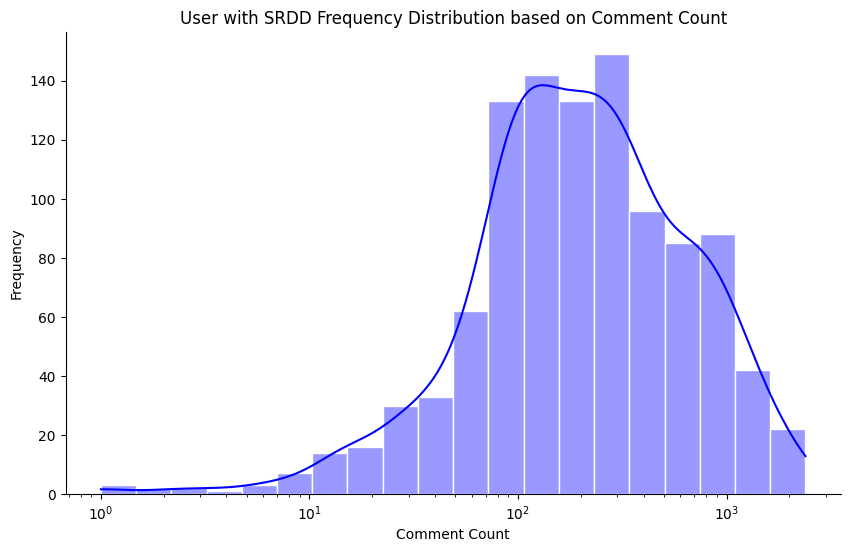

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# 1. first, take a look at the comment volume for each user
post_counts = filtered_df.groupby('author').size()

# 2. get a distribution plot of the comment volume with log x axis
plt.figure(figsize=(10, 6))
sns.histplot(post_counts, kde=True, bins=20, color='blue', edgecolor = 'white',alpha=0.4, log_scale=True)  # log_scale=True应用对数尺度
sns.despine()

plt.title('User with SRDD Frequency Distribution based on Comment Count')
plt.xlabel('Comment Count')
plt.ylabel('Frequency')
plt.show()



In [ ]:
# Use pre-trained language models to get sentiment and emotion prediction results

import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm import tqdm

# check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# load the language model
model_name = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

model.to(device)

# inference mode
model.eval()

# batch size
batch_size = 32

# results list
predicted_classes = []
confidence_scores = []

for i in tqdm(range(0, len(filtered_df), batch_size)):
    batch_texts = filtered_df['body'][i:i+batch_size].tolist()

    # tokenizer
    inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)


    # prediction
    with torch.no_grad():
        outputs = model(**inputs)

    # get the result
    predictions = outputs.logits.softmax(dim=-1)
    batch_predicted_classes = torch.argmax(predictions, dim=-1).tolist()
    batch_confidence_scores = predictions.tolist()

    # save the result
    predicted_classes.extend(batch_predicted_classes)
    confidence_scores.extend(batch_confidence_scores)



Using device: cuda


100%|██████████| 11734/11734 [1:06:31<00:00,  2.94it/s]


In [ ]:
# put the result into a dataframe
filtered_df['predicted_class'] = predicted_classes
filtered_df['confidence_scores'] = confidence_scores

<ipython-input-9-d36155fabf46>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['predicted_class'] = predicted_classes
<ipython-input-9-d36155fabf46>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['confidence_scores'] = confidence_scores


In [ ]:
# save the sentiment prediction results as a csv file

output_path = "/content/drive/MyDrive/Reddit/df_srdd_windowed_with_sentiment_labels.csv"
filtered_df.to_csv(output_path, index=False)

Same process for the comment data of contro users.
You can simply run the code again with the filepath changed to that of the control comments file.

# Next, we need to calibrate the results with a confidence score > 0.5

In [ ]:
# filter records with low probability

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

df_depressed = pd.read_csv('/content/drive/MyDrive/Reddit/df_srdd_windowed_with_sentiment_labels.csv', encoding = 'latin1')

Mounted at /content/drive


In [ ]:
df_depressed = df_depressed[df_depressed['confidence_scores'].notna()]
df_depressed

In [ ]:
import ast
df_depressed['confidence_scores'] = df_depressed['confidence_scores'].apply(ast.literal_eval)
labels = ['negative', 'neutral', 'positive']
df_depressed['max_score'] = df_depressed['confidence_scores'].apply(lambda x: max(x))
df_depressed['max_label'] = df_depressed['confidence_scores'].apply(lambda x: labels[x.index(max(x))] )
df_depressed = df_depressed[df_depressed['max_score'] > 0.5]
df_depressed

In [ ]:
import pandas as pd
from transformers import pipeline
from tqdm import tqdm
import torch

device = 0 if torch.cuda.is_available() else -1
print(f"Using device: {'GPU' if device == 0 else 'CPU'}")

pipe = pipeline(
    'text-classification',
    model="cardiffnlp/twitter-roberta-base-emotion-latest", # same process, but the model is emotion analysis mode here
    return_all_scores=True,
    truncation=True,
    device=device
)
batch_size = 32 if device == 0 else 16
emotion_scores = []

for i in tqdm(range(0, len(df_depressed), batch_size), desc="Processing in batches"):
    batch_texts = df_depressed['body'][i:i + batch_size].tolist()
    batch_scores = pipe(batch_texts)
    for scores in batch_scores:
        emotion_scores.append([score['score'] for score in scores])

# emotion confidence score
df_depressed['emotion_scores'] = emotion_scores
output_path = "/content/drive/MyDrive/Reddit/df_srdd_windowed_with_sentiment_and_emotion_labels.csv"
df_depressed.to_csv(output_path, index=False)
print(f"Results saved to {output_path}")



Using device: GPU


Processing in batches: 100%|██████████| 9385/9385 [52:24<00:00,  2.98it/s]
<ipython-input-15-7c5ec91d2b76>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_depressed['emotion_scores'] = emotion_scores


Results saved to /content/drive/MyDrive/Reddit/df_srdd_windowed_with_sentiment_and_emotion_labels.csv


# Now we need exclude records with emotion confidence score < 0.5

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
df_srdd = pd.read_csv('/content/drive/MyDrive/Reddit/df_srdd_windowed_with_sentiment_and_emotion_labels.csv', encoding = 'latin1')

Mounted at /content/drive


In [ ]:
df_srdd

In [ ]:
import ast
df_srdd['emotion_scores'] = df_srdd['emotion_scores'].apply(lambda x: ast.literal_eval(x))

In [ ]:
# emotion category mapping
emotion_map = {
    0: "anger",
    1: "anticipation",
    2: "disgust",
    3: "fear",
    4: "joy",
    5: "love",
    6: "optimism",
    7: "pessimism",
    8: "sadness",
    9: "surprise",
    10: "trust"
}

df_srdd['emotion_type'] = df_srdd['emotion_scores'].apply(
    lambda x: [emotion_map[i] for i, score in enumerate(x) if score > 0.5]
)

In [ ]:
multi_emotion_count = df_srdd[df_srdd['emotion_type'].apply(lambda x: len(x) > 1)].shape[0]

# count how many rows with multiple emotion caterories and how many rows are empty after using the calibration
empty_emotion_count = df_srdd[df_srdd['emotion_type'].apply(lambda x: len(x) == 0)].shape[0]

multi_emotion_count, empty_emotion_count

(189837, 44088)

In [ ]:
df_srdd

In [ ]:
# exclude rows with empty emotion labels
df_srdd_valid_labels = df_srdd[df_srdd['emotion_type'].apply(len) > 0]

In [ ]:
df_srdd_valid_labels

In [ ]:
df_srdd_valid_labels.to_csv("/content/drive/MyDrive/Reddit/df_srdd_windowed_valid_labels.csv",index = False)

In [ ]:
label_counts = df_srdd_valid_labels['max_label'].value_counts()
label_percentages = (label_counts / label_counts.sum()) * 100

# a summary of the final sentiment and emotion category
senti_summary_df = pd.DataFrame({
    'Count': label_counts,
    'Percentage': label_percentages
}).reset_index().rename(columns={'index': 'Sentiment Label'})

print(senti_summary_df)


  max_label   Count  Percentage
0  negative  131282   51.240398
1  positive   74535   29.091597
2   neutral   50391   19.668004


In [ ]:
# similarly, summarize the emotion category
emotion_counts = df_srdd_valid_labels['emotion_type'].explode().value_counts()

total_records = len(df_srdd_valid_labels)
emotion_percentages = (emotion_counts / total_records) * 100
emotion_summary_df = pd.DataFrame({
    'Count': emotion_counts,
    'Percentage': emotion_percentages
}).reset_index().rename(columns={'index': 'Emotion Type'})

print(emotion_summary_df)

    emotion_type   Count  Percentage
0            joy  100550   39.245457
1        disgust   84727   33.069615
2       optimism   81938   31.981047
3          anger   77166   30.118497
4   anticipation   57294   22.362299
5        sadness   55306   21.586367
6           love   26153   10.207722
7           fear   21486    8.386155
8      pessimism   13950    5.444795
9       surprise    6734    2.628333
10         trust    1423    0.555408


In [ ]:
# compute the percentage value for each author
author_sentiment_counts = df_srdd_valid_labels.groupby(['author', 'max_label']).size().unstack(fill_value=0)
author_total_counts = author_sentiment_counts.sum(axis=1)
author_sentiment_percentage = author_sentiment_counts.div(author_total_counts, axis=0) * 100

srdd_authors = pd.concat([author_total_counts,author_sentiment_counts, author_sentiment_percentage.add_suffix('_percentage')], axis=1).reset_index()


In [ ]:
srdd_authors.rename(columns={0: 'total_count'}, inplace=True)


In [ ]:
# similarly, compute the comment percentage under each emotion category for each user
emotion_exploded = df_srdd_valid_labels.explode('emotion_type')
author_emotion_counts = emotion_exploded.groupby(['author', 'emotion_type']).size().unstack(fill_value=0)

srdd_authors = srdd_authors.set_index('author')

for emotion in author_emotion_counts.columns:
    srdd_authors[f'{emotion}_count'] = author_emotion_counts[emotion].reindex(srdd_authors.index, fill_value=0)

srdd_authors = srdd_authors.reset_index()


In [ ]:
emotion_types = [col for col in srdd_authors.columns if col.endswith('_count') and col != 'total_count']

for emotion_count in emotion_types:
    emotion = emotion_count.replace('_count', '')
    srdd_authors[f'{emotion}_percentage'] = (srdd_authors[emotion_count] / srdd_authors['total_count']) * 100

In [ ]:
srdd_authors

In [ ]:
srdd_authors.to_csv('/content/drive/MyDrive/Reddit/srdd_authors.csv', index  = False)

# **Same process for df_control**

In [ ]:
df_control = pd.read_csv('/content/drive/MyDrive/Reddit/df_control_windowed_with_sentiment_and_emotion_labels.csv', encoding = 'latin1')

In [ ]:
df_control['emotion_scores'] = df_control['emotion_scores'].apply(lambda x: ast.literal_eval(x))
df_control['emotion_type'] = df_control['emotion_scores'].apply(
    lambda x: [emotion_map[i] for i, score in enumerate(x) if score > 0.5]
)
df_control_valid_labels = df_control[df_control['emotion_type'].apply(len) > 0]

In [ ]:
df_control_valid_labels.to_csv("/content/drive/MyDrive/Reddit/df_control_windowed_valid_labels.csv",index = False)

In [ ]:
label_counts_control = df_control_valid_labels['max_label'].value_counts()
label_percentages_control = (label_counts_control / label_counts_control.sum()) * 100
senti_summary_df_control = pd.DataFrame({
    'Count': label_counts_control,
    'Percentage': label_percentages_control
}).reset_index().rename(columns={'index': 'Sentiment Label'})

print(senti_summary_df_control)

  max_label   Count  Percentage
0  negative  116135   46.514096
1  positive   73455   29.420011
2   neutral   60087   24.065893


In [ ]:

emotion_counts_control = df_control_valid_labels['emotion_type'].explode().value_counts()
total_records_control = len(df_control_valid_labels)
emotion_percentages_control = (emotion_counts_control / total_records_control) * 100
emotion_summary_df_control = pd.DataFrame({
    'Count': emotion_counts_control,
    'Percentage': emotion_percentages_control
}).reset_index().rename(columns={'index': 'Emotion Type'})
print(emotion_summary_df_control)

    emotion_type   Count  Percentage
0            joy  101148   40.511541
1        disgust   83640   33.499281
2       optimism   78308   31.363722
3          anger   76323   30.568695
4   anticipation   65511   26.238300
5        sadness   37484   15.012997
6           love   22934    9.185468
7           fear   12341    4.942786
8       surprise    8111    3.248597
9      pessimism    7492    3.000677
10         trust    1379    0.552314


In [ ]:
control_authors = df_control_valid_labels.groupby('author').size()

In [ ]:

author_sentiment_counts_control = df_control_valid_labels.groupby(['unique_author', 'max_label']).size().unstack(fill_value=0)
author_total_counts_control = author_sentiment_counts_control.sum(axis=1)
author_sentiment_percentage_control = author_sentiment_counts_control.div(author_total_counts_control, axis=0) * 100
control_authors = pd.concat([author_total_counts_control,author_sentiment_counts_control, author_sentiment_percentage_control.add_suffix('_percentage')], axis=1).reset_index()
print(control_authors)

In [ ]:
control_authors.rename(columns={0: 'total_count'}, inplace=True)
emotion_exploded_control = df_control_valid_labels.explode('emotion_type')
author_emotion_counts_control = emotion_exploded_control.groupby(['unique_author', 'emotion_type']).size().unstack(fill_value=0)
control_authors = control_authors.set_index('unique_author')
for emotion in author_emotion_counts_control.columns:
    control_authors[f'{emotion}_count'] = author_emotion_counts_control[emotion].reindex(control_authors.index, fill_value=0)
control_authors = control_authors.reset_index()

In [ ]:
emotion_types_control = [col for col in control_authors.columns if col.endswith('_count') and col != 'total_count']
for emotion_count in emotion_types_control:
    emotion = emotion_count.replace('_count', '')
    control_authors[f'{emotion}_percentage'] = (control_authors[emotion_count] / control_authors['total_count']) * 100

In [ ]:
control_authors.to_csv('/content/drive/MyDrive/Reddit/control_authors.csv', index  = False)